# ESPCN ([Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158)) 

implemented using TensorFlow Lite

## Setup

For color space transformation, install OpenCV.

In [ ]:
!pip install opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 경로 설정
import os
import os, glob
import os.path
os.chdir('/content/gdrive/MyDrive/2021/AI-Cycle/SR')

In [ ]:
from PIL import Image

## Build the model

Import dependencies.

In [ ]:
import tensorflow as tf
import tarfile
import datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Conv2D, Input, Lambda, Activation
from tensorflow.python.keras.models import Model
from os.path import exists, join, basename
from os import makedirs, remove, path
from six.moves import urllib

Set some parameters and download BSD300 dataset.

In [ ]:
def download_dataset(file, target_dir="dataset", extract=True):
    if not exists(join(target_dir, "DIV2K/images/train")):
        source_url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
        target_dir = path.abspath(target_dir)
        tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)

# download_dataset('DIV2K_train_HR.zip')


In [ ]:
SCALE = 2
# LR_SIZE = 100
# Make sure HR_SIZE is smaller than 300 since some images in the dataset have height/width < 300
# HR_SIZE = LR_SIZE * SCALE
IMG_SIZE = 300
HR_SIZE = IMG_SIZE * SCALE

BATCH_SIZE = 100

In [ ]:
# Helper function to wrap depth_to_space op (pixel shuffle) in a Lambda layer
def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = Conv2D(64, [5, 5], padding='same', activation='relu')(input)
x = Conv2D(32, [3, 3], padding='same', activation='relu')(x)
x = Conv2D(SCALE**2, [3, 3], padding='same')(x)
x = Lambda(pixel_shuffle(scale=SCALE))(x)
x = Activation('tanh')(x)
model = Model(input, x, name="ESPCN")

logdir = "./logdir/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.MSE)

model.summary()

Model: "ESPCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 64)      1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 32)      18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 4)       1156      
_________________________________________________________________
lambda (Lambda)              (None, 600, 600, 1)       0         
_________________________________________________________________
activation (Activation)      (None, 600, 600, 1)       0         
Total params: 21,284
Trainable params: 21,284
Non-trainable params: 0
_________________________________________________________

## Video -> Frame

In [ ]:
import cv2
import os
from os.path import join

vidcap = cv2.VideoCapture('recycle.mp4')

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    current_directory = os.getcwd()
    path = os.path.join(current_directory, r'frame folder')
    if not os.path.exists(path):
      os.makedirs(path)
    if hasFrames:
        cv2.imwrite(os.path.join(path,"image"+str(count)+".jpg"), image)     # save frame as JPG file

    return hasFrames
sec = 0
frameRate = 0.05 #//it will capture image in each * second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

In [ ]:
TRAIN_IMAGES = "dataset/BSDS300+DIV2K/images/train/*.jpg"
TEST_IMAGES = "dataset/BSDS300+DIV2K/images/test/*.jpg"

ESPCN implements a simple network with 3 convolutional layers and 1 pixel shuffle layer on the Y channel (luminance) in the YCbCr color space. Cb and Cr channels are upsampled using bicubic method. We can prepare our training and test datasets as the following.

In [ ]:
def extract_luminance(path):
    img = cv2.imread(path.numpy().decode('UTF8'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # Extract luminance
    img_y = img[:, :, 0:1]
    return img_y

def load_image(img_path):
    [hr_img,] = tf.py_function(extract_luminance, [img_path], [tf.float32])
    hr_img = tf.convert_to_tensor(hr_img)
    hr_img = tf.image.random_crop(hr_img, [HR_SIZE, HR_SIZE, 1])
    hr_img = tf.cast(hr_img, tf.float32)
    hr_img = hr_img / 255.
    # lr_img = hr_img
    lr_img = tf.image.resize(hr_img, [HR_SIZE//SCALE, HR_SIZE//SCALE], tf.image.ResizeMethod.BICUBIC)
    return lr_img, hr_img


In [ ]:
training_dataset = tf.data.Dataset.list_files(TRAIN_IMAGES) \
                   .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.experimental.AUTOTUNE) \
                   .shuffle(buffer_size = 200) 

test_dataset = tf.data.Dataset.list_files(TEST_IMAGES) \
                   .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.experimental.AUTOTUNE)

## Train and export the model

In [ ]:
model.fit(training_dataset,epochs= 700,validation_data=test_dataset,
          callbacks = [tensorboard_callback]) # workers = 3

model.save("export_ep700")

Epoch 1/700
6/6 [==============================] - 25s 1s/step - loss: 0.0142 - val_loss: 0.0133
Epoch 2/700
6/6 [==============================] - 25s 1s/step - loss: 0.0132 - val_loss: 0.0126
Epoch 3/700
6/6 [==============================] - 25s 1s/step - loss: 0.0120 - val_loss: 0.0116
Epoch 4/700
6/6 [==============================] - 25s 1s/step - loss: 0.0114 - val_loss: 0.0112
Epoch 5/700
6/6 [==============================] - 25s 1s/step - loss: 0.0110 - val_loss: 0.0104
Epoch 6/700
6/6 [==============================] - 25s 1s/step - loss: 0.0103 - val_loss: 0.0111
Epoch 7/700
6/6 [==============================] - 25s 1s/step - loss: 0.0101 - val_loss: 0.0101
Epoch 8/700
6/6 [==============================] - 25s 1s/step - loss: 0.0102 - val_loss: 0.0103
Epoch 9/700
6/6 [==============================] - 25s 1s/step - loss: 0.0094 - val_loss: 0.0092
Epoch 10/700
6/6 [==============================] - 25s 1s/step - loss: 0.0095 - val_loss: 0.0098
Epoch 11/700
6/6 [===========

## Super resolve a test low resolution image using TensorFlow Lite.

In [ ]:
def load_test_image(img_path):
    hr = cv2.imread(img_path)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2YCrCb)
    hr = tf.image.crop_to_bounding_box(hr, 0, 300, IMG_SIZE, IMG_SIZE)
    # lr = tf.image.resize(hr, [HR_SIZE//SCALE, HR_SIZE//SCALE])
    lr = hr
    lr = tf.cast(lr, tf.uint8)
    return lr, hr

def super_resolve(original_img_path):
    # lr - low resolution image
    # hr - high resolution image (cropped from original)
    # sr - super resolved image from lr
    lr, hr = load_test_image(original_img_path)
    lr_ycrcb = lr.numpy().copy()    
    lr = cv2.cvtColor(lr.numpy(), cv2.COLOR_YCrCb2RGB)
    hr = cv2.cvtColor(hr.numpy(), cv2.COLOR_YCrCb2RGB)   
    lr_ycrcb = tf.cast(lr_ycrcb, tf.float32)
    lr_y = lr_ycrcb[:, :, 0:1] / 255.
    lr_cr = lr_ycrcb[:, :, 1:2]
    lr_cb = lr_ycrcb[:, :, 2:3]
    lr_y = tf.expand_dims(lr_y, axis=0)
    
    # Use TFLite to super resolve luminance
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], lr_y)
    interpreter.invoke()
    sr_y = interpreter.get_tensor(output_details[0]['index'])
    open("ESPCN.tflite", 'wb').write(tflite_model)
    
    # Transform super resolved image back into RGB color space
    sr_y = sr_y * 255
    sr_cr = tf.image.resize(lr_cr, [IMG_SIZE*SCALE, IMG_SIZE*SCALE], tf.image.ResizeMethod.BICUBIC)
    sr_cb = tf.image.resize(lr_cb, [IMG_SIZE*SCALE, IMG_SIZE*SCALE], tf.image.ResizeMethod.BICUBIC)
    sr = tf.concat([sr_y[0], sr_cr, sr_cb], axis=2)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    sr = cv2.cvtColor(sr.numpy(), cv2.COLOR_YCrCb2RGB)
    return lr, sr, hr



In [ ]:
# test_img_path = "dataset/BSDS300/images/test/170057.jpg"
# test_img_path = "dataset/BSDS300/images/test/recycle1.jpg"
test_img_path = "./frame folder/"
test_img_name = "image"

current_directory = os.getcwd()
lrimage = os.path.join(current_directory, r'frame folder_lr')
if not os.path.exists(lrimage):
  os.makedirs(lrimage)
srimage = os.path.join(current_directory, r"frame folder_sr")
if not os.path.exists(srimage):
  os.makedirs(srimage)

from PIL import Image
from tensorflow import keras 
model = keras.models.load_model('./export')

count = 0
for path in os.listdir(test_img_path):
    if os.path.isfile(os.path.join(test_img_path, path)):
        count += 1

for i in range(count):
  lr, sr, hr = super_resolve(test_img_path+"image"+str(i+1)+".jpg")

  # psnr = tf.image.psnr(sr, hr, 255).numpy()
  # print('PSNR:', psnr)

  im = Image.fromarray(lr)
  im.save("./frame folder_lr/lrimage"+str(i+1)+".jpg")

  im = Image.fromarray(sr)
  im.save("./frame folder_sr/srimage"+str(i+1)+".jpg")

INFO:tensorflow:Assets written to: /tmp/tmp37w2o36z/assets
INFO:tensorflow:Assets written to: /tmp/tmprm6gluwp/assets


INFO:tensorflow:Assets written to: /tmp/tmprm6gluwp/assets


INFO:tensorflow:Assets written to: /tmp/tmp6jcoyvaa/assets


INFO:tensorflow:Assets written to: /tmp/tmp6jcoyvaa/assets


INFO:tensorflow:Assets written to: /tmp/tmpd511k8mx/assets


INFO:tensorflow:Assets written to: /tmp/tmpd511k8mx/assets


INFO:tensorflow:Assets written to: /tmp/tmpn1fr2pr2/assets


INFO:tensorflow:Assets written to: /tmp/tmpn1fr2pr2/assets


INFO:tensorflow:Assets written to: /tmp/tmprvnuccf3/assets


INFO:tensorflow:Assets written to: /tmp/tmprvnuccf3/assets


INFO:tensorflow:Assets written to: /tmp/tmpu2gwoled/assets


INFO:tensorflow:Assets written to: /tmp/tmpu2gwoled/assets


INFO:tensorflow:Assets written to: /tmp/tmpc7q9jn5l/assets


INFO:tensorflow:Assets written to: /tmp/tmpc7q9jn5l/assets


INFO:tensorflow:Assets written to: /tmp/tmp8dxtctmg/assets


INFO:tensorflow:Assets written to: /tmp/tmp8dxtctmg/assets


INFO:tensorflow:Assets written to: /tmp/tmpbkaict4t/assets


INFO:tensorflow:Assets written to: /tmp/tmpbkaict4t/assets


INFO:tensorflow:Assets written to: /tmp/tmpjirgvv0g/assets


INFO:tensorflow:Assets written to: /tmp/tmpjirgvv0g/assets


INFO:tensorflow:Assets written to: /tmp/tmphk7mslw4/assets


INFO:tensorflow:Assets written to: /tmp/tmphk7mslw4/assets


INFO:tensorflow:Assets written to: /tmp/tmp15231qmg/assets


INFO:tensorflow:Assets written to: /tmp/tmp15231qmg/assets


INFO:tensorflow:Assets written to: /tmp/tmp2eif9qy0/assets


INFO:tensorflow:Assets written to: /tmp/tmp2eif9qy0/assets


INFO:tensorflow:Assets written to: /tmp/tmpo_zh2rar/assets


INFO:tensorflow:Assets written to: /tmp/tmpo_zh2rar/assets


INFO:tensorflow:Assets written to: /tmp/tmp2m09yy50/assets


INFO:tensorflow:Assets written to: /tmp/tmp2m09yy50/assets


INFO:tensorflow:Assets written to: /tmp/tmph3rsg25w/assets


INFO:tensorflow:Assets written to: /tmp/tmph3rsg25w/assets


INFO:tensorflow:Assets written to: /tmp/tmpwnrvpbrg/assets


INFO:tensorflow:Assets written to: /tmp/tmpwnrvpbrg/assets


INFO:tensorflow:Assets written to: /tmp/tmp0bzeq_qi/assets


INFO:tensorflow:Assets written to: /tmp/tmp0bzeq_qi/assets


INFO:tensorflow:Assets written to: /tmp/tmprl15u6vi/assets


INFO:tensorflow:Assets written to: /tmp/tmprl15u6vi/assets


INFO:tensorflow:Assets written to: /tmp/tmpl8ct0m4o/assets


INFO:tensorflow:Assets written to: /tmp/tmpl8ct0m4o/assets


INFO:tensorflow:Assets written to: /tmp/tmpmuu74onq/assets


INFO:tensorflow:Assets written to: /tmp/tmpmuu74onq/assets


INFO:tensorflow:Assets written to: /tmp/tmp_q277l0k/assets


INFO:tensorflow:Assets written to: /tmp/tmp_q277l0k/assets


INFO:tensorflow:Assets written to: /tmp/tmpobuy2j4_/assets


INFO:tensorflow:Assets written to: /tmp/tmpobuy2j4_/assets


INFO:tensorflow:Assets written to: /tmp/tmp5kefcw2_/assets


INFO:tensorflow:Assets written to: /tmp/tmp5kefcw2_/assets


INFO:tensorflow:Assets written to: /tmp/tmp68z_avrx/assets


INFO:tensorflow:Assets written to: /tmp/tmp68z_avrx/assets


INFO:tensorflow:Assets written to: /tmp/tmp6t6ae2rd/assets


INFO:tensorflow:Assets written to: /tmp/tmp6t6ae2rd/assets


INFO:tensorflow:Assets written to: /tmp/tmphlv3dyb2/assets


INFO:tensorflow:Assets written to: /tmp/tmphlv3dyb2/assets


INFO:tensorflow:Assets written to: /tmp/tmplkxp28s6/assets


INFO:tensorflow:Assets written to: /tmp/tmplkxp28s6/assets


INFO:tensorflow:Assets written to: /tmp/tmpf4feta1j/assets


INFO:tensorflow:Assets written to: /tmp/tmpf4feta1j/assets


INFO:tensorflow:Assets written to: /tmp/tmpgkp5i5pr/assets


INFO:tensorflow:Assets written to: /tmp/tmpgkp5i5pr/assets


INFO:tensorflow:Assets written to: /tmp/tmpr38r1_3q/assets


INFO:tensorflow:Assets written to: /tmp/tmpr38r1_3q/assets


INFO:tensorflow:Assets written to: /tmp/tmp16x8e2sb/assets


INFO:tensorflow:Assets written to: /tmp/tmp16x8e2sb/assets


INFO:tensorflow:Assets written to: /tmp/tmpofroinz6/assets


INFO:tensorflow:Assets written to: /tmp/tmpofroinz6/assets


INFO:tensorflow:Assets written to: /tmp/tmpz7wa8d30/assets


INFO:tensorflow:Assets written to: /tmp/tmpz7wa8d30/assets


INFO:tensorflow:Assets written to: /tmp/tmpa65zpuvf/assets


INFO:tensorflow:Assets written to: /tmp/tmpa65zpuvf/assets


INFO:tensorflow:Assets written to: /tmp/tmpp1a53c50/assets


INFO:tensorflow:Assets written to: /tmp/tmpp1a53c50/assets


INFO:tensorflow:Assets written to: /tmp/tmpmx0x8q9i/assets


INFO:tensorflow:Assets written to: /tmp/tmpmx0x8q9i/assets


INFO:tensorflow:Assets written to: /tmp/tmptbjv281w/assets


INFO:tensorflow:Assets written to: /tmp/tmptbjv281w/assets


INFO:tensorflow:Assets written to: /tmp/tmp4pc_9p5p/assets


INFO:tensorflow:Assets written to: /tmp/tmp4pc_9p5p/assets


INFO:tensorflow:Assets written to: /tmp/tmpwdflh0yn/assets


INFO:tensorflow:Assets written to: /tmp/tmpwdflh0yn/assets


INFO:tensorflow:Assets written to: /tmp/tmpv4944r18/assets


INFO:tensorflow:Assets written to: /tmp/tmpv4944r18/assets


INFO:tensorflow:Assets written to: /tmp/tmphbe3vlzz/assets


INFO:tensorflow:Assets written to: /tmp/tmphbe3vlzz/assets


INFO:tensorflow:Assets written to: /tmp/tmpnc_fb__z/assets


INFO:tensorflow:Assets written to: /tmp/tmpnc_fb__z/assets


INFO:tensorflow:Assets written to: /tmp/tmpn1f9qc4z/assets


INFO:tensorflow:Assets written to: /tmp/tmpn1f9qc4z/assets


INFO:tensorflow:Assets written to: /tmp/tmpmcefrgyi/assets


INFO:tensorflow:Assets written to: /tmp/tmpmcefrgyi/assets


INFO:tensorflow:Assets written to: /tmp/tmpqszebxaq/assets


INFO:tensorflow:Assets written to: /tmp/tmpqszebxaq/assets


INFO:tensorflow:Assets written to: /tmp/tmp975vtka1/assets


INFO:tensorflow:Assets written to: /tmp/tmp975vtka1/assets


INFO:tensorflow:Assets written to: /tmp/tmpwkhnd9g3/assets


INFO:tensorflow:Assets written to: /tmp/tmpwkhnd9g3/assets


INFO:tensorflow:Assets written to: /tmp/tmpjjp9hl8j/assets


INFO:tensorflow:Assets written to: /tmp/tmpjjp9hl8j/assets


INFO:tensorflow:Assets written to: /tmp/tmph3yonz84/assets


INFO:tensorflow:Assets written to: /tmp/tmph3yonz84/assets


INFO:tensorflow:Assets written to: /tmp/tmpaky6ja_h/assets


INFO:tensorflow:Assets written to: /tmp/tmpaky6ja_h/assets


INFO:tensorflow:Assets written to: /tmp/tmpi9oemblf/assets


INFO:tensorflow:Assets written to: /tmp/tmpi9oemblf/assets


INFO:tensorflow:Assets written to: /tmp/tmp5yevbhre/assets


INFO:tensorflow:Assets written to: /tmp/tmp5yevbhre/assets


INFO:tensorflow:Assets written to: /tmp/tmpqhqq5iyt/assets


INFO:tensorflow:Assets written to: /tmp/tmpqhqq5iyt/assets


INFO:tensorflow:Assets written to: /tmp/tmpclgud_y2/assets


INFO:tensorflow:Assets written to: /tmp/tmpclgud_y2/assets


INFO:tensorflow:Assets written to: /tmp/tmp_im9t65i/assets


INFO:tensorflow:Assets written to: /tmp/tmp_im9t65i/assets


INFO:tensorflow:Assets written to: /tmp/tmpd_3xr19o/assets


INFO:tensorflow:Assets written to: /tmp/tmpd_3xr19o/assets


## Visualize the result

PSNR ([Peak Signal-to-Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)) is a commonly used metric to measure the image recovery quality.

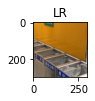

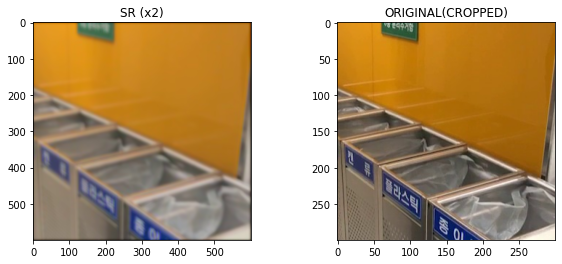

In [ ]:
# print("PSNR of super resolved image: %f", tf.image.psnr(sr, hr, 255).numpy())  

plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr);


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'SR (x{SCALE})')
plt.imshow(sr);


plt.subplot(1, 2, 2)   
plt.title('ORIGINAL(CROPPED)')
plt.imshow(hr);

## Frame -> Video

In [ ]:
import cv2
import numpy as np
import os
from os.path import isfile, join
pathIn= './frame folder_sr/'
pathOut = 'video_0.05s.avi'
fps = 20
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly

from natsort import natsorted
#files.sort(key = lambda x: x[5:-4])
#files.sort()
files = natsorted(files)

frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly

#files.sort(key = lambda x: x[5:-4])
files = natsorted(files)

for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()